In [1]:
import pandas as pd
import numpy as np
from station import Station
import seaborn as sns
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload
import geopy.distance
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [2]:
# read in data files
ride_df = pd.read_csv('data/CTA_-_Ridership_-__L__Station_Entries_-_Daily_Totals.csv')
map_df = pd.read_csv('data/CTA_-_System_Information_-_List_of__L__Stops.csv')
station_map_names = {'Lake':'Lake/State', 'Jackson':'Jackson/State',
                     'Washington':'Washington/Dearborn'}
map_df.replace({"STATION_NAME": station_map_names}, inplace=True)

In [3]:
station_list = ride_df.stationname.unique().tolist()
sumlist = []
for station in station_list:
    stat = Station(station, ride_df, map_df)
    sumlist.append(stat.summary)
station_summary = pd.DataFrame(sumlist)    
station_summary.to_csv('data/station_summary.csv')

In [4]:
# station_summary = pd.read_csv('data/station_summary.csv')
to_remove = station_summary[station_summary['Sat_mean'] == 0].index[0]
station_summary.drop([to_remove], inplace=True)

station_summary['weekday-sat'] = station_summary['Weekday_mean'
                                                ] - station_summary['Sat_mean']

station_summary['weekday-sun'] = station_summary['Weekday_mean'
                                                ] - station_summary['Sun/Hol_mean']

In [5]:
high_stds = station_summary.sort_values(by='daily_std', ascending=False).iloc[0:9]
high_stations = high_stds.station.tolist()
high_stds.set_index('station', inplace=True)

In [6]:
for stat in high_stations:
    stat = Station(stat, ride_df, map_df)
    stat.make_layered_hist('daytype')

hist_Clark_Lake_daytype.png
hist_Lake_State_daytype.png
hist_Jackson_State_daytype.png
hist_Washington_State_daytype.png
hist_Addison-North Main_daytype.png
hist_95th_Dan Ryan_daytype.png
hist_Washington_Wabash_daytype.png
hist_Washington_Dearborn_daytype.png
hist_Fullerton_daytype.png


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [7]:
for stat in high_stations:
    stat = Station(stat, ride_df, map_df)
    stat.make_layered_hist('season')

hist_Clark_Lake_season.png
hist_Lake_State_season.png
hist_Jackson_State_season.png
hist_Washington_State_season.png
hist_Addison-North Main_season.png
hist_95th_Dan Ryan_season.png
hist_Washington_Wabash_season.png
hist_Washington_Dearborn_season.png
hist_Fullerton_season.png


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

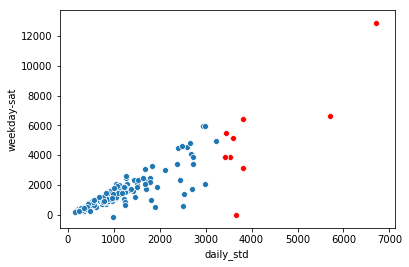

In [8]:
fig, ax = plt.subplots()
sns.scatterplot(x="daily_std", y="weekday-sat", data=station_summary, ax=ax)
sns.scatterplot(x="daily_std", y="weekday-sat", data=high_stds, color='red', ax=ax)

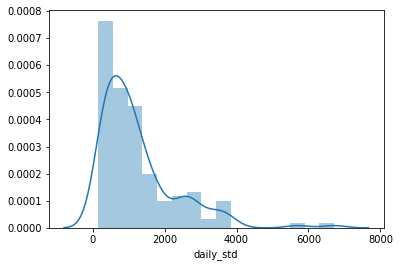

In [9]:
sns.distplot(station_summary['daily_std'])

In [19]:
# create geodataframe from stations with highest STDs
geometry = [Point(x,y) for x,y in zip(high_stds['longitude'], high_stds['latitude'])]
crs = {'init':'epsg:4326'}
geo_df = gpd.GeoDataFrame(index=high_stds.index, crs=crs, geometry=geometry)

In [20]:
neigh_map = gpd.read_file(
    'data/Boundaries - Community Areas/geo_export_c539fca7-2c77-4148-be09-2c656a4bc388.shp')
# get representative coordinates from each neighborhood
neigh_map['coords'] = neigh_map['geometry'].apply(
    lambda x: x.representative_point().coords[:])
neigh_map['coords'] = [coords[0] for coords in neigh_map['coords']]
neigh_map.set_index('community', inplace=True)

In [21]:
assign_dict = {key: geom for key, geom in neigh_map['geometry'].items()}
assign_dict2 = {key: geo_df.within(geom) for key, geom in assign_dict.items()}
# check which neighborhood each station falls in
station_to_neigh = geo_df.assign(**assign_dict2)
station_to_neigh = station_to_neigh.loc[:, (station_to_neigh != 0).any(axis=0)]

In [23]:
ncols = ['LAKE VIEW', 'LOOP', 'ROSELAND', 'LINCOLN PARK']
station_to_neigh['neighborhood'] = station_to_neigh[ncols].idxmax(axis=1)
station_to_neigh.drop(columns=ncols, inplace=True)

In [24]:
for item in station_to_neigh['neighborhood']:
    inds = station_to_neigh.index[station_to_neigh['neighborhood']==item].tolist()
    station_to_neigh.loc[inds,'polygon'] = neigh_map.loc[item, 'geometry']

In [25]:
neigh_to_station = station_to_neigh.copy()
neigh_to_station.rename(columns={'polygon':'geometry', 'geometry':'points'}, inplace=True)

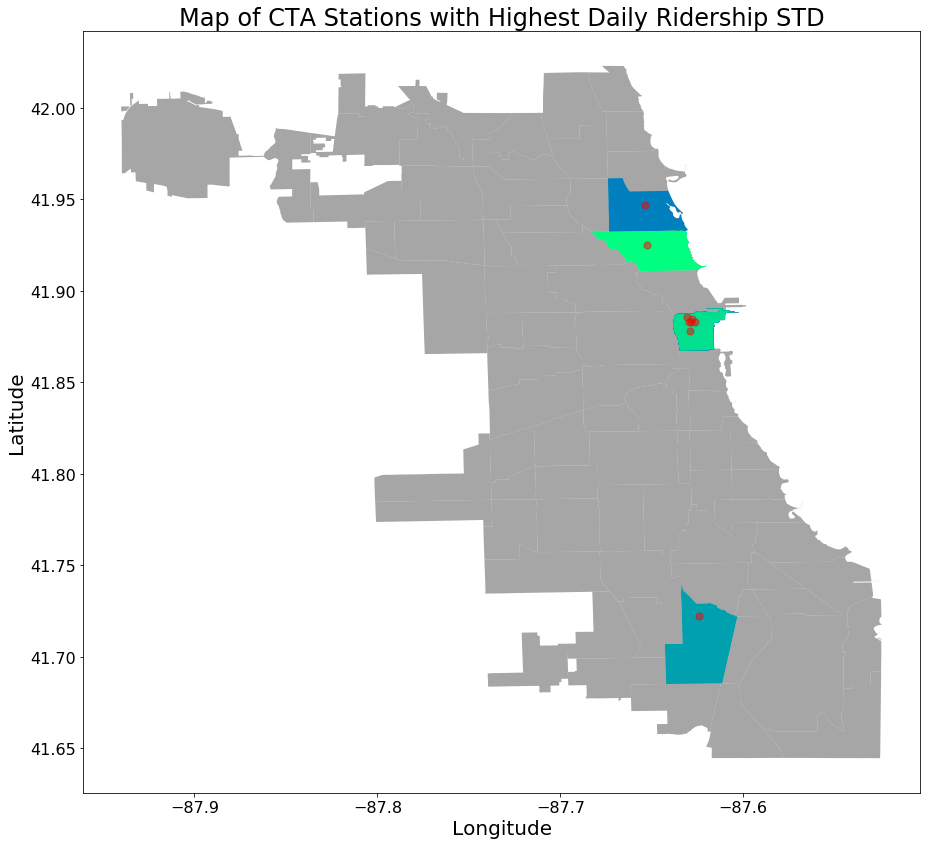

In [26]:
fig, ax = plt.subplots(figsize=(15,15))
neigh_map.plot(ax=ax,alpha=.7, color='grey')
neigh_to_station.plot(ax=ax,cmap='winter')
station_to_neigh.plot(ax=ax, color='red', marker='o', alpha=.5, markersize=50)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=16)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=16)
plt.title('Map of CTA Stations with Highest Daily Ridership STD', fontsize=24)

plt.savefig('figs/map_high_daily_stds.png')
